In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import importlib
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.cluster import SpectralBiclustering
import ipywidgets as widgets
from ipywidgets import interact
from ipypublish import nb_setup
import drought_ibf_utility as ibf
importlib.reload(ibf)
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=1.2)
pd = nb_setup.setup_pandas(escape_latex=False)
used_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

# Summary
Here we train and optimize a logistic regression model to predict the occurrence of droughts in Uganda based of meteorological data. The precipitation and the **E**nhanced **V**egitation **I**ndex (EVI) turn out to be the most important drought predictors among all the meteorological quantities that we studied, implying that the drought reports are triggered by both the hydrological and agricultural factors. The model is able to capture 70 percent of the reported droughts in our historical data. Based on our model, we derive a “drought score” which would serve as a potentially useful metric to monitor and predict droughts in Uganda. We show that this drought score also strongly correlates with the Dry Matter Productivity (DMP) data.

# Data collection

Our aim is to construct a model to predict the occurrence of droughts in Uganda, using meteorological satellite data. The meteorological parameters that serve as drought indicators, and to which we refer as **features**, are collected using the [Google Earth engine](https://developers.google.com/earth-engine/python_install) by this [python script](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/GoogleEarthEngine/GEE_get_data.py), and are listed bellow

  
- [**NDVI:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2) *'***N***ormalized ***D***ifference ***V***egitation ***I***ndex'* (scale by 0.0001).    
- [**EVI:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2) *'***E***nhanced ***V***egitation ***I***ndex'* (scale by 0.0001). 
- [**precipitation:**](https://developers.google.com/earth-engine/datasets/catalog/TRMM_3B43V7#bands): Rainfall in mm/hrs. Name in our dataset: '`precipitation per hour v1`'.
- [**hourlyPrecipRate:**](https://developers.google.com/earth-engine/datasets/catalog/JAXA_GPM_L3_GSMaP_v6_operational) Rainfall measured in mm/hrs. Name in our dataset: '`precipitation per hour v2`'. 
- [**LST_Day_1km:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) Land surface temperature during daytime in  50 Kelvins. Name in our dataset: '`surface temperature daytime`'.
- [**LST_Night_1km:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) Land surface temperature during daytime in  50 Kelvins. Name in our dataset: '`surface temperature nighttime`'.
- [**Evap_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Evapotranspiration measured in kg m^{-2} s^{-1}. Name in our dataset: '`evapotranspiration`'.
- [**Rainf_f_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Precipitation rate measured in kg m^{-2} s^{-1}  Name in our dataset: '`rainfall`'. 
- [**SoilMoi00_10cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (0 - 10 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture00 10cm`'.
- [**SoilMoi10_40cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (10 - 40 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture10 40cm`'.
- [**SoilMoi40_100cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (40 - 100 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture40 100cm`'.
- [**SoilMoi100_200cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (100 - 200 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture100 200cm`'.
- [**SoilTemp00_10cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (0 - 10 cm underground) in K. Name in our dataset: '`SoilTemperature00 10cm`'.
- [**SoilTemp10_40cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (10 - 40 cm underground) in K. Name in our dataset: '`SoilTemperature10 40cm`'. 
- [**SoilTemp40_100cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (40 - 100 cm underground) in K. Name in our dataset: '`SoilTemperature40 100cm`'.
- [**SoilTemp100_200cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (100 - 200 cm underground) in K. Name in our dataset: '`SoilTemperature100 200cm`'.
- [**Tair_f_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Near surface air temperature in K. Name in our dataset: '`air temperature`'.
- [**Wind_f_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Near surface wind speed in m/s. Name in our dataset: '`wind speed`'.  
- [**SPEI** columns:](https://spei.csic.es/) We calculated the *‘***S***tandardized ***P***recipitation-***E***vapotranspiration ***I***ndex’* from the columns '`rainfall`' and '`evapotranspiration`' in our dataset, using the published [R package](https://spei.csic.es/tools.html). We have used different *scale* parameters from 1 to 12 months, generating the columns '`SPEI 1month`' to '`SPEI 12month`'. The R script to perform this calculation can be find [here](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/SPEI_satellite/calc_SPEI.R).

All features were averaged over each district (i.e.  admin. level 1), and either averaged or summed in successive one-month intervals (see this [python script](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/GoogleEarthEngine/GEE_get_data.py) for details).

The target variable that we are trying to predict, to which we refer to as the **label**, is the occurrence of droughts at a certain time point/period in a particular district. This would be a binary (i.e. Boolean) variable, taking the value 'True' when a drought has occurred, and 'False' when no drought is reported. This information comes from two different sources, the Red Cross desinventar and news articles, both can be found [here](https://rodekruis.sharepoint.com/sites/510-CRAVK-510/Gedeelde%20%20documenten/Forms/AllItems.aspx?RootFolder=%2Fsites%2F510%2DCRAVK%2D510%2FGedeelde%20%20documenten%2F%5BCTRY%5D%20Uganda%2F2%2D%20IBF%20DROUGHT%20UGANDA%2FDROUGHT%20EVENTS%20%26%20IMPACT%20ANALYSIS&FolderCTID=0x012000D122CA8FA5B68345A13A32EDAA653915) (see Figure \ref{fig_drought_reports}). We chose to build the label variable by  combining the two sources together. This is represented by the column '`drought reported`' in the dataset. 

We merged all the features and labels into a single dataset using this [Jupyter notebook](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/combining%20satellite%20data%20with%20desinventar%20events%20and%20news%20article%20events%20.ipynb). The resultant dataset can be found [here](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/datasets/Droughts_satelite_and_events.csv). Each row of the dataset corresponds to a unique pair of date and district.

In [2]:
phath='./datasets/'
filename='Droughts_satelite_and_events.csv'
full_data = pd.read_csv(phath + filename, index_col=False)
Uganda_data = full_data[full_data.Country == 'Uganda'].copy()


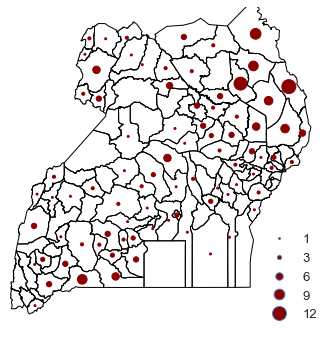

In [3]:
ibf.plot_droughts_per_district(Uganda_data)

# Data preprocessing

We consider the bimodal [agricultural calendar for Uganda](https://fews.net/east-africa/uganda) (Figure \ref{fig:calendar}, top panel) which has two harvest seasons per year: the first one during June and July, and the second one in November and December.  

![agricultural calendar for Uganda](./pictures/seasonal-calendar-uganda.png){#fig:calendar width=100%}

We set as our goal to predict whether or not a drought occurs within each harvest season, based on the meteorological data in the three-month period preceding the season. To this end we redefine the label variable to have the value `True` if a drought is reported in any of the two months of the season, and `False` otherwise. We also average all the meteorological data, except SPEI, over the preceding three-month period and use them as features for our model. For SPEI we use the column '` SPEI 3month`' and take the data points that correspond to the three-month period before each harvest season. We then normalize all features except `SPEI` per district and season. This means that for any given district and season, we calculate the mean and the standard deviation of each feature during all years, and then standardize the feature by subtracting the mean and dividing by the standard deviation. The `SPEI` feature is already normalized by construction.  
The transformed dataset can be downloaded from [here](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/datasets/Uganda_seasonal_normalized.csv). Each row is indicated by a unique triple of district, year and season. The first harvest season is indicated by `6_7` and the second one by `11_12`.

In [4]:
data = ibf.prepare_Uganda_data(save=True)

data.head()

,year,District,Season,EVI,NDVI,SPEI 3month,SoilMoisture00 10cm,SoilMoisture10 40cm,SoilMoisture100 200cm,SoilMoisture40 100cm,...,SoilTemperature40 100cm,air temperature,evapotranspiration,precipitation per hour v1,precipitation per hour v2,rainfall,surface temperature daytime,surface temperature nighttime,wind speed,drought reported
0,2000,ABIM,11_12,0.635496,0.232554,0.946693,0.876312,0.736812,0.199678,0.605763,...,-0.552902,-0.435935,1.208654,1.601028,-0.469460,1.336204,-0.151764,-1.343323,-0.412148,False
1,2000,ABIM,6_7,-1.590836,-1.720571,0.075238,-1.302612,-1.262019,-1.113239,-0.937505,...,1.414168,1.570308,-0.740945,-0.358292,-1.030145,-0.388903,1.260564,0.032762,0.306375,False
2,2000,ADJUMANI,11_12,-1.085335,-1.260320,-0.606487,-0.724946,-0.683251,-0.722124,-0.829818,...,0.199455,-0.221168,-1.138716,0.041021,-2.093348,-1.024165,1.721439,-1.782573,-0.412293,False
3,2000,ADJUMANI,6_7,-2.697474,-3.056846,-0.816605,-0.872943,-0.161562,0.243240,0.000243,...,1.332993,1.546512,-0.115219,-1.671680,-1.859843,-0.681410,2.350867,-0.480881,0.608132,False
4,2000,AGAGO,11_12,1.149972,-0.070580,0.824262,0.874588,0.793872,0.624983,0.710458,...,-0.539216,-0.380892,1.126550,1.366786,0.265181,0.963633,-0.414698,-2.063056,-0.467823,False


In [5]:
id_cols = ['year','District','Season']
label_name = 'drought reported'
All_features = list(data.drop(labels=id_cols+[label_name],axis=1).columns)
selected_features = All_features

As a final step of preparing the training data, we decided to only keep those rows in the dataset that correspond to either a year with a reported drought or a year preceding/following a drought. This will potentially reduce the noise in the data due to the droughts that have actually happened but remained unreported.

In [6]:
reduced_data = ibf.reduce_data(data,label_name)

# Data exploration

## Correlations among the features

Many of the features in our dataset are strongly correlated. To investigate this, we used a [biclustering algorithm](https://scikit-learn.org/stable/modules/biclustering.html) to divide the features into three separate groups. Features within a group correlate strongly with each other, while the correlation between features from different groups is weaker. Figure \ref{corr_mat} Shows the resultant correlation matrix, where the colors represent the absolute value of the correlation coefficient. We can see that the soil moisture and soil temperature features all correlate strongly with each other, as expected. Vegetation indices EVI and NDVI correlate well with each other, with air and surface temperatures, and with the soil temperature (but not with the soil moisture). Surprisingly the features related to precipitation, namely '`rainfall`', '` precipitation_per_hour_v1`' and '` precipitation_per_hour_v2`', do not correlate well with each other. The reason for this is not clear for us.

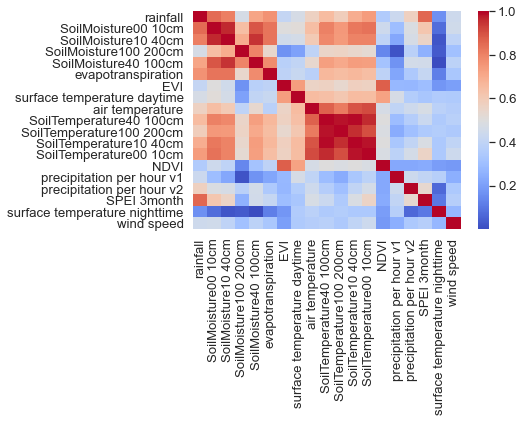

In [7]:
features = reduced_data[All_features].copy()
feature_corr = features.corr().abs()

bicluster_model = SpectralBiclustering(n_clusters=3, method='log',
                             random_state=0)
bicluster_model.fit(feature_corr)
feature_corr_sorted = feature_corr.values[np.argsort(bicluster_model.row_labels_),:]
feature_corr_sorted = feature_corr_sorted[:, np.argsort(bicluster_model.column_labels_)]
rows = feature_corr.columns[np.argsort(bicluster_model.row_labels_)]
cols = feature_corr.columns[np.argsort(bicluster_model.column_labels_)]
feature_corr_sorted = pd.DataFrame(feature_corr_sorted,index=rows,columns=cols)
sns.heatmap(feature_corr_sorted,cmap='coolwarm');
loc,labels =plt.xticks()
plt.yticks(ticks=loc,labels=list(labels));

The correlation plots among the features within each of the three groups are shown in Figures \ref{pairplot1} to \ref{pairplot3}.

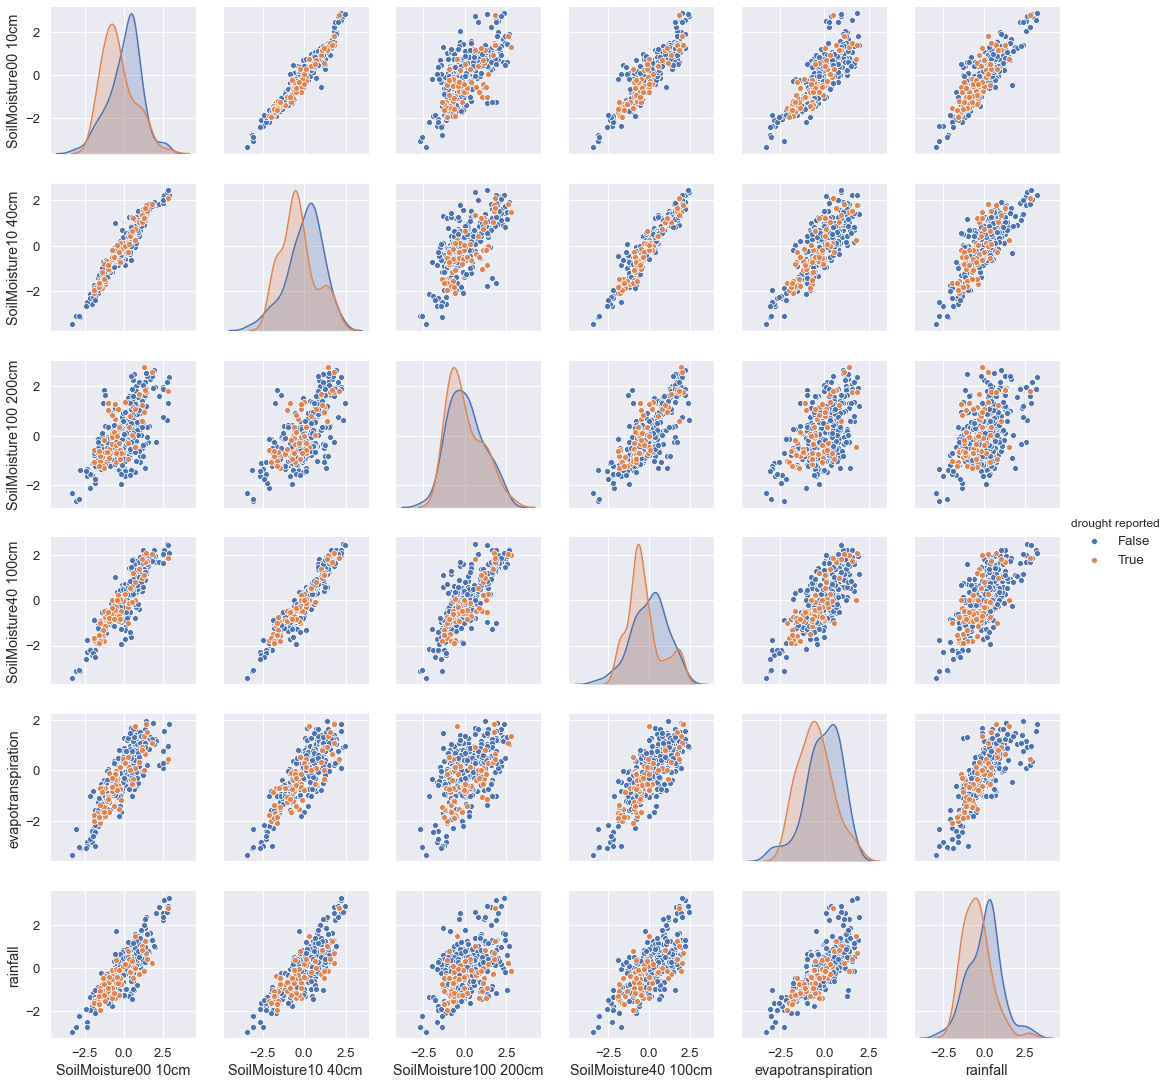

In [8]:
gruop_0 = feature_corr.columns[bicluster_model.row_labels_==0] 
sns.pairplot(reduced_data, vars=gruop_0, hue=label_name);

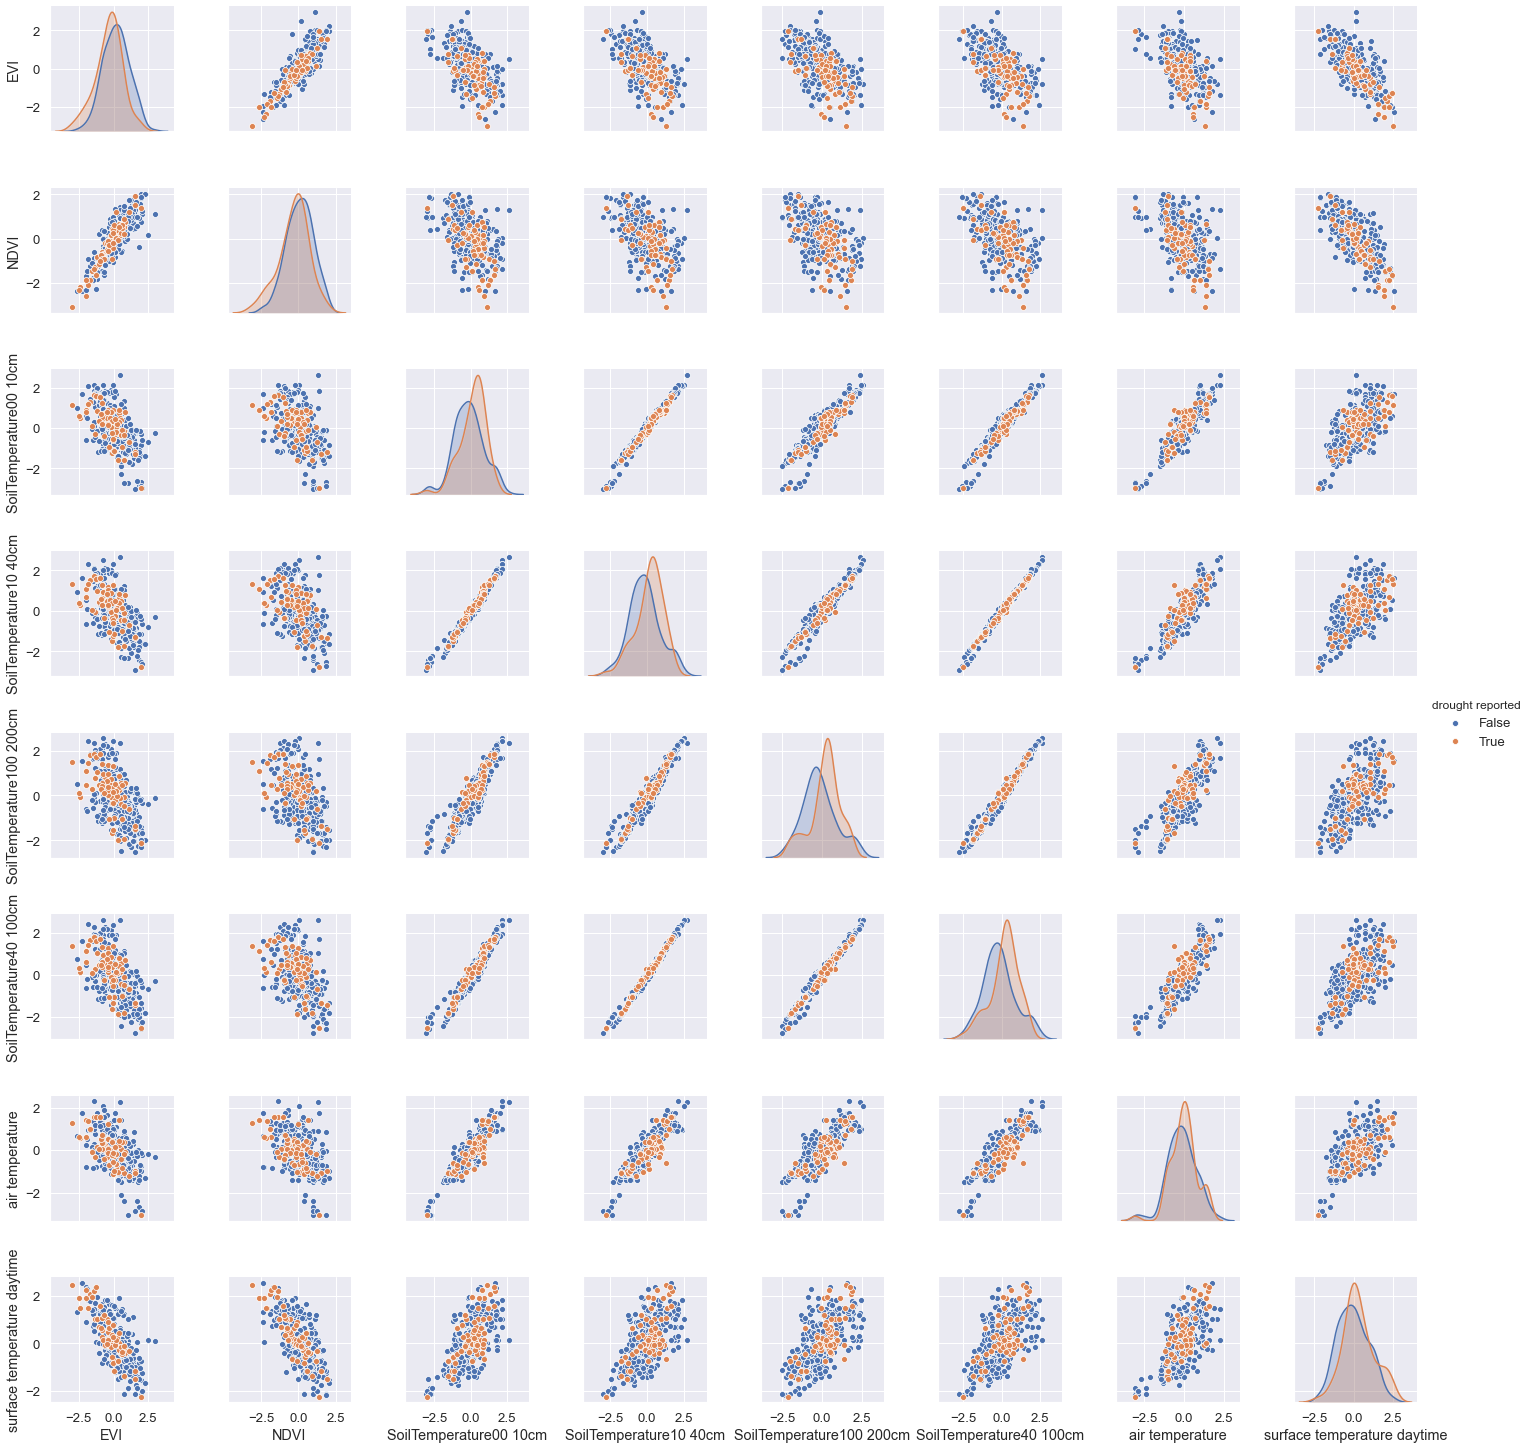

In [9]:
gruop_1 = feature_corr.columns[bicluster_model.row_labels_==1]
sns.pairplot(reduced_data, vars=gruop_1, hue=label_name);

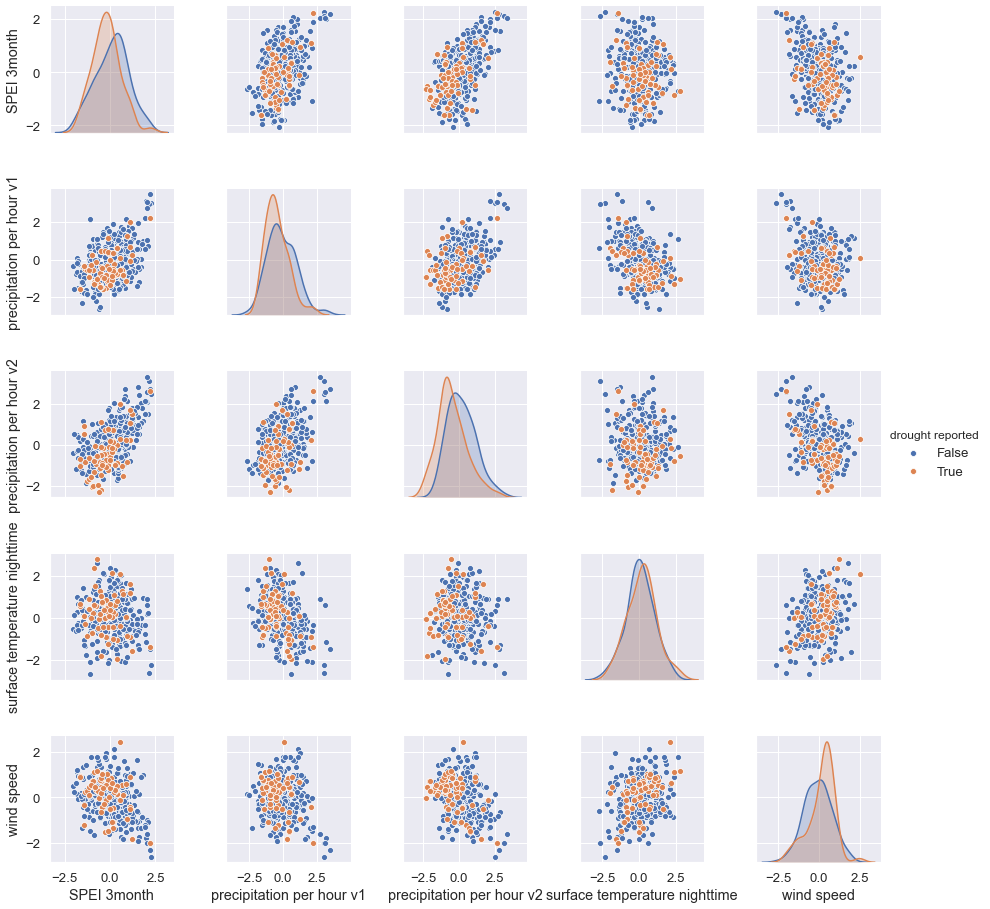

In [10]:
gruop_2 = feature_corr.columns[bicluster_model.row_labels_==2]
sns.pairplot(reduced_data, vars=gruop_2, hue=label_name);

## Correlation with the target

Figures \ref{fig_dist1} to \ref{fig_dist19} show the distribution of each feature separately for '`drought reported =False`' (blue) and '`drought reported = True`' (orange). The medians of the distributions, as well as the absolute values of the difference between them, are reported in Table \ref{tlabe_median}. The features are ranked in descending order according to the difference in medians. From Table \ref{tlabe_median} it is clear that the features that are related to precipitation, either directly or indirectly, are important drought predictors. 

In [11]:
median_vals = reduced_data[All_features+[label_name]].groupby(label_name).median().T.reset_index()
median_vals.rename(columns={True:'yes drought', 
                            False:'no drought', 
                            'Is_drought':'index',
                           'index':'feature'}, inplace= True)
median_vals['difference'] = (median_vals['yes drought']-median_vals['no drought']).abs()
median_vals.sort_values('difference',ascending=False,inplace=True)
median_vals.reset_index(inplace=True,drop=True)
median_vals.columns.name = None 
median_vals

,feature,no drought,yes drought,difference
0,SoilMoisture00 10cm,0.280299,-0.570226,0.850525
1,precipitation per hour v2,0.063213,-0.698218,0.761430
2,SoilMoisture10 40cm,0.216020,-0.530722,0.746742
3,SoilMoisture40 100cm,0.203412,-0.531513,0.734925
4,evapotranspiration,0.044880,-0.602795,0.647675
5,rainfall,0.158049,-0.486975,0.645024
6,SoilTemperature100 200cm,-0.268359,0.320006,0.588365
7,SoilTemperature40 100cm,-0.224721,0.361192,0.585913
8,SoilTemperature10 40cm,-0.211171,0.302455,0.513625
9,SoilTemperature00 10cm,-0.144578,0.340174,0.484752


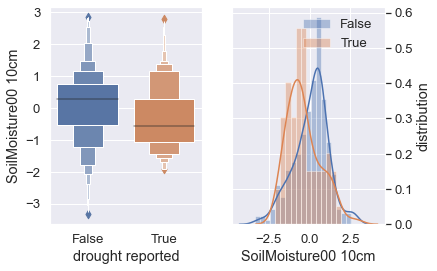

In [12]:
target = 'SoilMoisture00 10cm'
ibf.plot_dist(reduced_data,target,label_name)

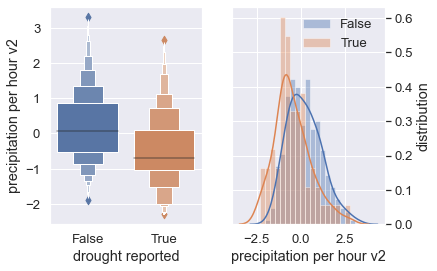

In [13]:
target = 'precipitation per hour v2'
ibf.plot_dist(reduced_data,target,label_name)

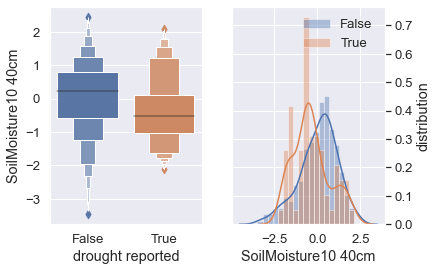

In [14]:
target = 'SoilMoisture10 40cm'
ibf.plot_dist(reduced_data,target,label_name)

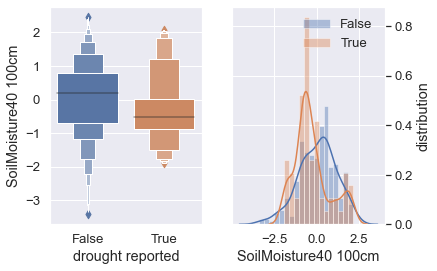

In [15]:
target = 'SoilMoisture40 100cm'
ibf.plot_dist(reduced_data,target,label_name)

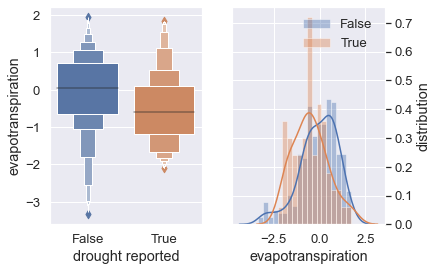

In [16]:
target = 'evapotranspiration'
ibf.plot_dist(reduced_data,target,label_name)

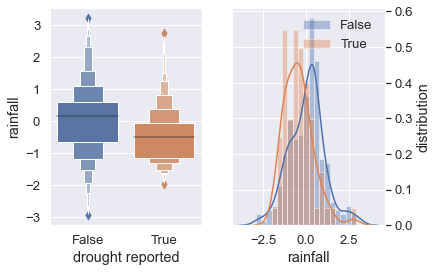

In [17]:
target = 'rainfall'
ibf.plot_dist(reduced_data,target,label_name)

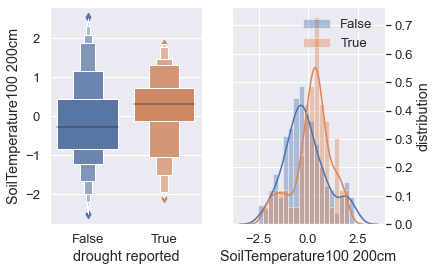

In [18]:
target = 'SoilTemperature100 200cm'
ibf.plot_dist(reduced_data,target,label_name)

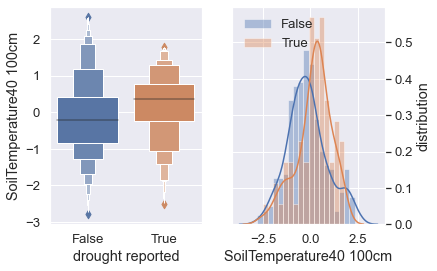

In [19]:
target = 'SoilTemperature40 100cm'
ibf.plot_dist(reduced_data,target,label_name)

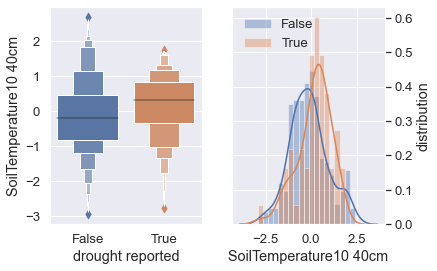

In [20]:
target = 'SoilTemperature10 40cm'
ibf.plot_dist(reduced_data,target,label_name)

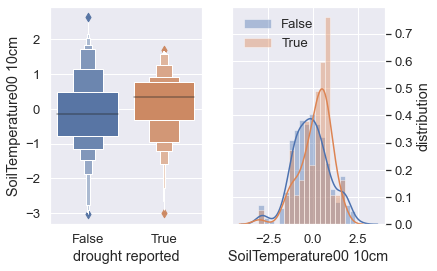

In [21]:
target = 'SoilTemperature00 10cm'
ibf.plot_dist(reduced_data,target,label_name)

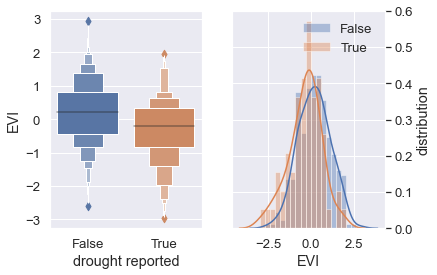

In [22]:
target = 'EVI'
ibf.plot_dist(reduced_data,target,label_name)

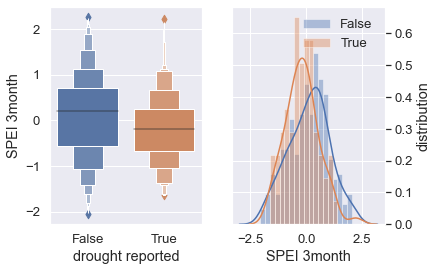

In [23]:
target = 'SPEI 3month'
ibf.plot_dist(reduced_data,target,label_name)

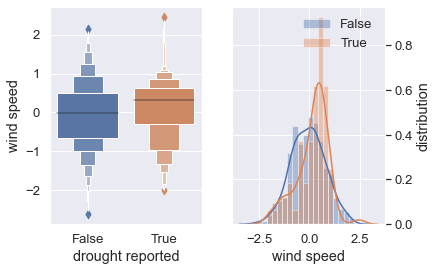

In [24]:
target = 'wind speed'
ibf.plot_dist(reduced_data,target,label_name)

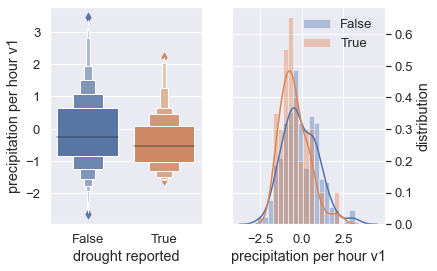

In [25]:
target = 'precipitation per hour v1'
ibf.plot_dist(reduced_data,target,label_name)

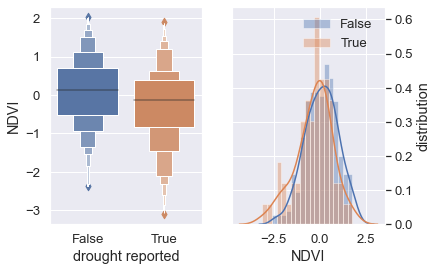

In [26]:
target = 'NDVI'
ibf.plot_dist(reduced_data,target,label_name)

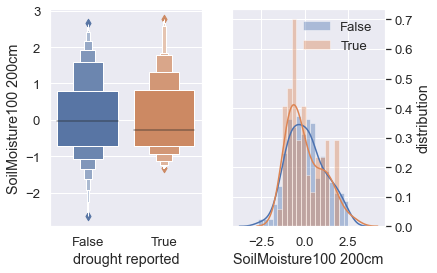

In [27]:
target = 'SoilMoisture100 200cm'
ibf.plot_dist(reduced_data,target,label_name)

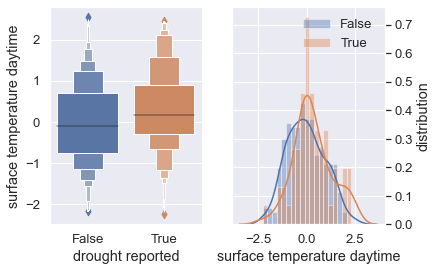

In [28]:
target = 'surface temperature daytime'
ibf.plot_dist(reduced_data,target,label_name)

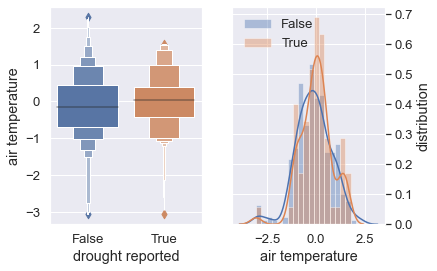

In [29]:
target = 'air temperature'
ibf.plot_dist(reduced_data,target,label_name)

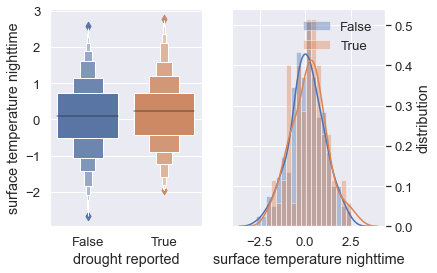

In [30]:
target = 'surface temperature nighttime'
ibf.plot_dist(reduced_data,target,label_name)

# Fitting and optimizing a Logistic Regression model

We train a [logistic regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with [$l_1$ penalty](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html) to predict the occurrence of droughts in Uganda. Our goal is to separate the rows of the dataset into two classes: a positive class which represents the occurrence of a drought, (`drought = True`), and a negative class where the model predicts that no drought will occur (`drought = False`). It is important to note that the population of the positive class $n^{pos}= 65$ in the reduced dataset is about 5 times smaller the population of the negative class $n^{neg}= 297$. The negative class is therefore largely overrepresented, and a model trained on such data will be biased towards predicting the negative class correctly, without caring so much about capturing the positive class. Since having a good predicting power for the positive class is equally important for us, we need to correct for this imbalance in the class populations. We do this by assigning unequal weights $W^{pos}$ and $W^{neg}$ to the positive and the negative classes, which are inversely proportional to the class populations:  

\begin{equation}\label{eqn_wpos}
W^{pos}=\frac{1}{n^{pos}},
\end{equation}

and

\begin{equation}\label{eqn_wneg}
W^{neg}=\frac{1}{n^{neg}}.
\end{equation}

Feeding these weights into the logistic regression model guarantees that both classes are represented equally when the model is trained on the data.

The $l_1$ penalty in the logistic regression model is associated with a regularization parameter $C$, which tunes the model complexity by controlling the number of features that are included in the model. In the framework of logistic regression, the contribution of each feature is determined by a coefficient, and a zero coefficient means that the corresponding feature does not enter the model. The regularization parameter determines how many of these coefficients are different from zero. Figure \ref{fig_l1} shows the model coefficients for all features as a function of the regularization parameter $C$. We can see that for large values of $C$ all coefficients are non-zero. As $C$ decreases, the coefficients gradually shrink to zero.

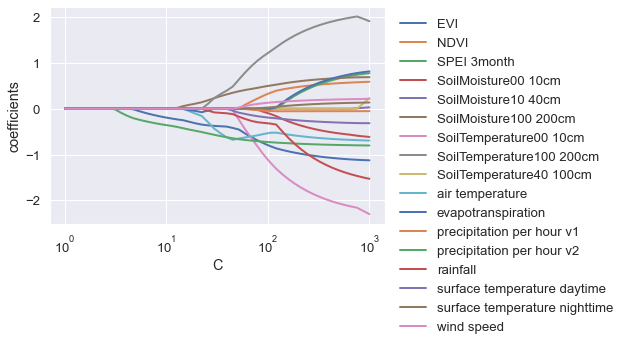

In [31]:
All_coefs = pd.DataFrame()

All_coefs['feature'] = selected_features

C_array = np.logspace(0,3,50)

for C in C_array:
    coefs,_,_,_,_,_ = ibf.predict_Logreg_model(data, selected_features, label_name, C, 
                                             confusion_matrix=False,drop_zero_coefs=False)
    All_coefs[C] = coefs['coefficients']
    
All_coefs = All_coefs.set_index('feature').T.reset_index()
All_coefs.rename(columns={'index':'C'},inplace=True)

to_drop = (All_coefs.std()[All_coefs.std()==0].index)

All_coefs.drop(labels=to_drop,axis=1).plot(logx=True,x='C',lw=2);
plt.legend(bbox_to_anchor=(1.01, 1));
plt.ylabel('coefficients');

Choosing an appropriate value for the regularization parameter is important, as this systematically eliminates unimportant and redundant features, so that only the most important features remain in the model. To find the best value for $C$, we fallow the standard procedure of splitting the data based on date and thereby dividing it into three equal-size separate sets: a train set (Figure \ref{fig_split} blue), a validation set (Figure \ref{fig_split} orange) and a test set (Figure \ref{fig_split} green). Train and validation sets are used to optimize the model by finding the best value of $C$, while the test set is reserved to evaluate the optimized model afterwards.

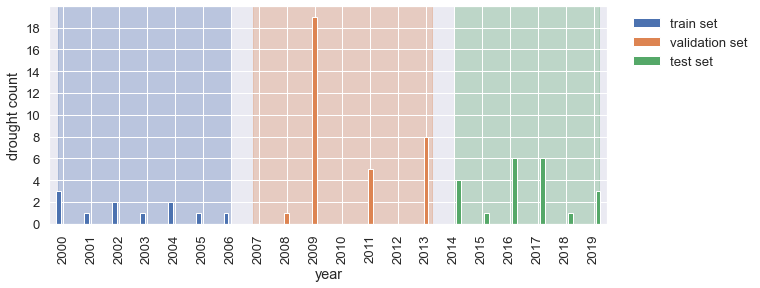

In [32]:
train_years = [int(2000),int(2007)]
val_years = [int(2007),int(2014)]
test_years = [int(2014),int(2020)]

All_years = pd.DataFrame()
All_years['year'] = range(2000,2020)
drought_count_yearly = reduced_data[['year',label_name]].groupby('year').sum().reset_index()
drought_count_train = drought_count_yearly[(drought_count_yearly.year>=train_years[0])&(drought_count_yearly.year<train_years[1])].copy()
drought_count_train.rename(columns={label_name:'train set'},inplace=True)
drought_count_val = drought_count_yearly[(drought_count_yearly.year>=val_years[0])&(drought_count_yearly.year<val_years[1])].copy()
drought_count_val.rename(columns={label_name:'validation set'},inplace=True)
drought_count_test = drought_count_yearly[(drought_count_yearly.year>=test_years[0])&(drought_count_yearly.year<test_years[1])].copy()
drought_count_test.rename(columns={label_name:'test set'},inplace=True)
drought_count_train = All_years.merge(drought_count_train,on='year',how='outer').fillna(0).set_index('year')
drought_count_val = All_years.merge(drought_count_val,on='year',how='outer').fillna(0).set_index('year')
drought_count_test = All_years.merge(drought_count_test,on='year',how='outer').fillna(0).set_index('year')
drought_count_All = drought_count_train.merge(drought_count_val,right_index=True,left_index=True)
drought_count_All = drought_count_All.merge(drought_count_test,right_index=True,left_index=True)
drought_count_All.plot.bar(figsize=(10,4))
plt.yticks(np.arange(0,20,2));
plt.ylabel('drought count')
ax = plt.gca()
ax.axvspan(-0.2, 6,zorder=0,alpha=0.3,color=used_colors[0])
ax.axvspan(6.8, 13.2,zorder=0,alpha=0.3,color=used_colors[1])
ax.axvspan(14, 19.2,zorder=0,alpha=0.3,color=used_colors[2])
plt.legend(bbox_to_anchor=(1.025, 1));

The optimization procedure is as follows. We considered a set of 1000 (logarithmically spaced) distinct values of $C$ and, for each value in the set, we built a logistic regression model on the train set. Then we evaluated each model on the validation set, using the [F1 score](https://en.wikipedia.org/wiki/F1_score) for the positive class as the goodness of fit measure. As Figure \ref{fig_cv} shows, the highest value of the score is reached at about $C=12$ (see the black dashed line).

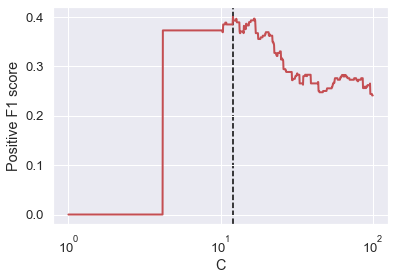

In [33]:
C_array = np.logspace(0,2,1000)

opt_model,test_scores =ibf.optimize_Logreg_model(data, selected_features, label_name, C_array,
                                                    train_years = train_years,val_years = val_years)

plt.semilogx(C_array,test_scores,color=used_colors[3],lw=2)
plt.ylabel('Positive F1 score');
plt.axvline(x=opt_model.C,zorder=0,color='black',ls='--')
plt.xlabel('C');

We then merged the train and validation sets together, retrained the optimal model (i.e. with $C=12$) on this combined set, and evaluated the model on the test set. The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and the accuracy associated with the optimal model, as well as [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall) and the F1 scores for positive and negative classes, are given in Text \ref{tab_confusion}. The model reaches the overall accuracy of ~ 60%, and has an impressive recall of ~ 70% for the positive class (which means that the model captures 70% of the reported droughts). On the other hand, the precision for the positive class is rather low: about %25. This is partially due to the overrepresentation of the negative class, which leads to many false positives, and lowers the precision for the positive class as well as the recall for the negative class. We note however that there is a rather high chance that an actual drought in Uganda remains unreported. We therefore expect that the number of false positives presented in Text \ref{tab_confusion} is an overestimation. The actual predictive power of the model can only be assessed after testing it in the field.  

In [34]:
C=opt_model.C
test_coefs, predictions, pr, roc, auc = ibf.predict_Logreg_model_split(data, 2014, selected_features, label_name, 
                                                                  C, confusion_matrix=True)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        14                 7
Actual negative        44                55

Accuracy  0.57
 
           Positive      Negative
Num case       21            99
Precision    0.24          0.89
Recall       0.67          0.56
F-score      0.35          0.68


To have a baseline with which we can compare the performance of our model, we consider a “random model” which classifies the data by “coin flipping”: irrespective to the features values, the model assigns `True` and `False` labels to the data points with equal probability. Text \ref{tab_random} lists the fit quality metrics for such a random model (averaged over 100 runs). We see that our model clearly outperforms the random model in every aspect, especially in the case of the positive class.

In [35]:
_,_= ibf.fit_random_model(reduced_data[label_name])

           Positive      Negative
Precision    0.18          0.82
Recall       0.50          0.50
F_score      0.26          0.62


Figure \ref{fig_pr} shows the [precision-recall curve](https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used) and the [receiver operating characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the optimal model. The area under the ROC curve ([auc](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)) is a metric commonly used to assess the predictive power of binary classifiers. A perfect classifier has an auc of one, while for a random classifier auc equals 0.5. Our model reaches auc of ~ 0.7.

Having optimized and evaluated the model, we retrain the optimal model on the whole data (train, validation and test sets combined) and use it as a working model in the following sections.

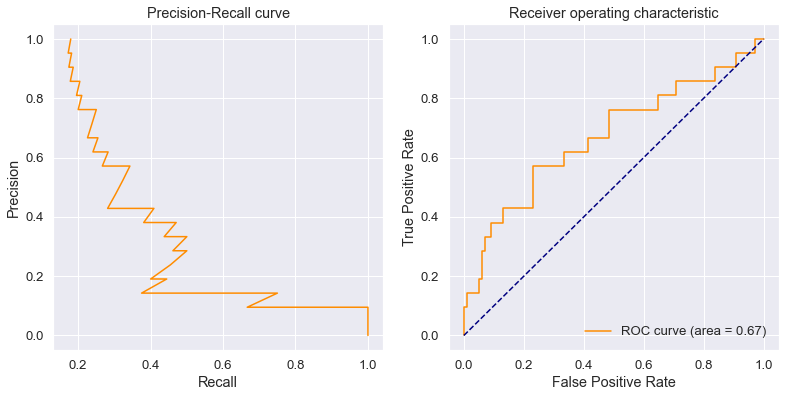

In [36]:
f,axs = plt.subplots(1,2,figsize=(13, 6))

axs[0].plot(pr[0],pr[1],color='darkorange')
axs[0].set_xlabel('Recall');
axs[0].set_ylabel('Precision');
axs[0].title.set_text('Precision-Recall curve')


axs[1].plot(roc[0],roc[1],color='darkorange',
         label='ROC curve (area = %0.2f)' % auc)
axs[1].plot([0,1],[0,1],'--',color='navy')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate');
plt.legend(loc="lower right")
axs[1].title.set_text('Receiver operating characteristic');

In [37]:
C=opt_model.C
coefs,predictions,_,_,_,opt_model = ibf.predict_Logreg_model(data, selected_features, label_name, C, 
                                                             confusion_matrix=True)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        45                20
Actual negative       126               171

Accuracy  0.60
 
           Positive      Negative
Num case       65           297
Precision    0.26          0.90
Recall       0.69          0.58
F-score      0.38          0.70


# Drought score

A logistic regression model produces a score as a linear combination of the features, where the contribution of each feature is determined by its associated coefficient. Table \ref{tab_coefs} lists the nonzero coefficients for our optimal drought model with $C=12$. Interestingly, only two features, ‘`precipitation per hour v2`’ and ‘`EVI`’, enter the optimal model, implying that the drought reports are triggered by both the hydrological and agricultural factors. According to Table \ref{tab_coefs}, the score produced by our optimal drought model can therefore be written as 

\begin{equation}\label{eqn_score}
\textrm{score}=-0.39\,\times\,\textrm{'precipitation per hour v2'}-0.23\,\times\,\textrm{'EVI'}.
\end{equation}

In [38]:
coefs.set_index('feature').apply(lambda x:round(x,2)) 

,coefficients
feature,
precipitation per hour v2,-0.39
EVI,-0.23


Note that, as mentioned earlier, in equation \ref{eqn_score} both features are normalized per district and per season. The score can be positive or negative, and is a measure for the likelihood of droughts. The more positive the score is, the higher is the chance that a drought occurs. Figure \ref{fig_score} shows the distribution of this "drought score" separately for '`drought reported =False`' (blue) and '`drought reported = True`' (orange), confirming that the score correlates with the target.

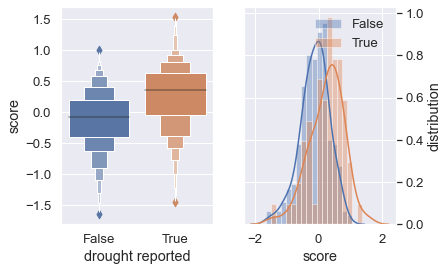

In [39]:
ibf.plot_dist(predictions.rename(columns={'logit_scores':'score'}), 
              'score', label_name)

# Drought prediction: successes and failures   

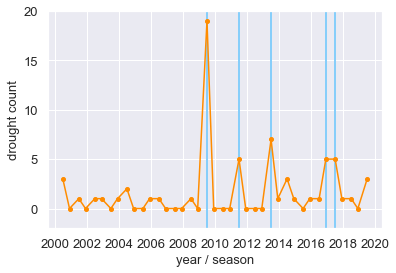

In [40]:
drought_count = data[['year', 'Season', label_name]].groupby(['year', 'Season']).sum().rename(
    columns={label_name: 'drought_count'}).reset_index()
drought_count['date'] = drought_count.apply(lambda x: date(x.year,
                                                           int(x.Season.split('_')[1]), 1),
                                            axis=1)
drought_count[['date', 'drought_count']].plot(x='date', marker='o',ms=4,
                                              color='darkorange',
                                              legend=False,zorder=7 )
ax = plt.gca()

year = 2009
season = '6_7'
date_1 = date(year, int(season.split('_')[0]), 1)
date_2 = date(year, int(season.split('_')[1]), 1)
ax.axvspan(date_1, date_2, color='lightskyblue')

year = 2011
season = '6_7'
date_1 = date(year, int(season.split('_')[0]), 1)
date_2 = date(year, int(season.split('_')[1]), 1)
ax.axvspan(date_1, date_2, color='lightskyblue')

year = 2013
season = '6_7'
date_1 = date(year, int(season.split('_')[0]), 1)
date_2 = date(year, int(season.split('_')[1]), 1)
ax.axvspan(date_1, date_2, color='lightskyblue')

year = 2016
season = '11_12'
date_1 = date(year, int(season.split('_')[0]), 1)
date_2 = date(year, int(season.split('_')[1]), 1)
ax.axvspan(date_1, date_2, color='lightskyblue')

year = 2017
season = '6_7'
date_1 = date(year, int(season.split('_')[0]), 1)
date_2 = date(year, int(season.split('_')[1]), 1)
ax.axvspan(date_1, date_2, color='lightskyblue')

fontsize = 13
plt.ylabel('drought count',fontsize=fontsize)
plt.xlabel('year / season',fontsize=fontsize)
plt.ylim([-2, 19])
plt.yticks(range(0, 21, 5),fontsize=fontsize);
plt.xticks(fontsize=fontsize);

Figure \ref{fig_droughtcount_seasonal} shows the number of reported droughts in Uganda during each harvest season between 2000 and 2019. Specifically, a large number of reports have been appeared in June-July 2009. Figure \ref{fig_map2009} shows the distribution of our drought score (equation \ref{eqn_score}) over the whole contry during this period: the score is generally positive and large. The model similarly captures the reported droughts (highlighted in Figure \ref{fig_droughtcount_seasonal}) in 2011 (Figure \ref{fig_map2011}) and 2016 (Figure \ref{fig_map2016}).

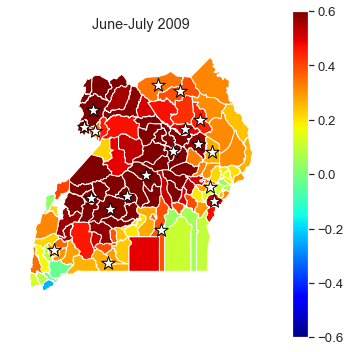

In [41]:
year = 2009
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

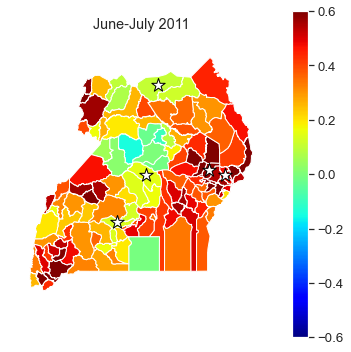

In [42]:
year = 2011
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

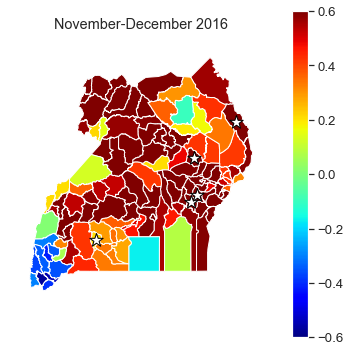

In [43]:
year = 2016
season = '11_12'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)


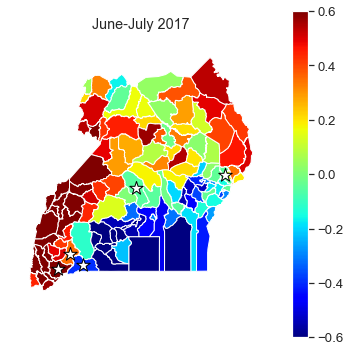

In [44]:
year = 2017
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

However, the model is not always successful. For example, it captures only some of the droughts in 2011 (see \ref{fig_map2017}), and in 2013 it fails drastically (see Figure \ref{fig_map2013a}): it produces a low score anywhere within the country while seven droughts has bin reported. In an attempt to rationalize this, we slightly modified the drought score: instead of considering the three-month period preceding June 2013, we calculated the score over the period of May to June 2013. As Figure \ref{fig_map2013b} shows, this modification improves the model performance in this particular instance. We therefore suggest that the failure of the model might be due to an unusually rapid change in the meteorological factors.

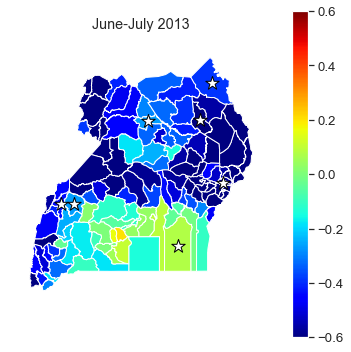

In [45]:
year = 2013
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

In [46]:
data_nolag = ibf.prepare_Uganda_data(first_planting = [5,6,7],
                       second_planting = [10,11,12])

selected_features_nolag = list(data_nolag.drop(labels=id_cols+[label_name],axis=1).columns)

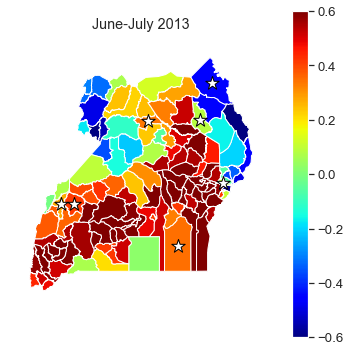

In [47]:
year = 2013
season = '6_7'

ibf.visualize_droughts_uganda(data_nolag,opt_model,year,season,
                              selected_features=selected_features_nolag,
                             label_name=label_name)

# Generalizing the model towards a drought-monitoring tool

We looked into the potential of our model as a drought-monitoring tool. To this end, we generalized our drought score in such a way that it can be calculated continuously over time, instead of being limited to just a three-month period prior to any harvest season. This is done by averaging the features using a sliding temporal window with a period of three months, normalizing them per month and district as described in Section \ref{data-collection}, and calculating the drought score using equation \ref{eqn_score}.

In [48]:
C=opt_model.C
monitor_features = ['precipitation per hour v2', 'EVI']
### reconstructing the optimal model with two features
monitor_model = ibf.make_monitor_model(data, monitor_features, label_name,
                                   C=C)
label_col = label_name
date_col = 'date'
path_to_DMP = './datasets/Uganda_DMP_data.csv'

monitor_data = ibf.prepare_monitor_data(Uganda_data,monitor_features,
                                    monitor_model,label_col=label_name,path_to_DMP=path_to_DMP)

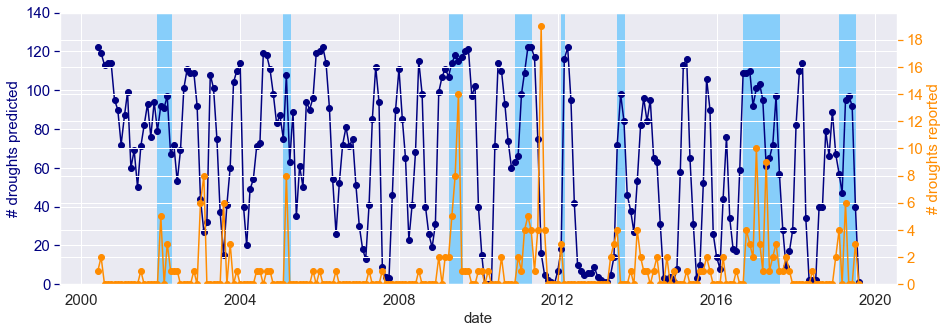

In [49]:
drought_count = monitor_data[[date_col,label_col,'drought_predicted']].dropna().groupby(date_col).sum()

plt.figure(figsize=(15,5))
plt.plot(drought_count.index,drought_count['drought_predicted'],marker='o',color='navy')
plt.xlabel('date',fontsize=15)
plt.ylabel('# droughts predicted',fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
#plt.legend(['droughts predicted'],loc=2,fontsize=15)
plt.ylim([0,140])
ax=plt.gca()
ax.yaxis.label.set_color('navy')
ax.tick_params(axis='y', colors='navy')
ax2=ax.twinx()
ax2.plot(drought_count.index,drought_count[label_col],marker='o',color='darkorange')
plt.ylabel('# droughts reported',fontsize=15)
ax2.yaxis.label.set_color('darkorange')
ax2.tick_params(axis='y', colors='darkorange')
plt.yticks(range(0, 20, 2),fontsize=15);
#plt.legend(['droughts reported'],loc=1,fontsize=15)
plt.ylim([0,20])
date_1 = date(2001, 12, 1)
date_2 = date(2002,4, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2005, 2, 1)
date_2 = date(2005,4, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2009, 4, 1)
date_2 = date(2009,8, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2010, 12, 1)
date_2 = date(2011,5, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2012, 2, 1)
date_2 = date(2012,3, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2013, 7, 1)
date_2 = date(2013,9, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2016, 9, 1)
date_2 = date(2017,8, 1)
ax.axvspan(date_1, date_2, color='lightskyblue')
date_1 = date(2019, 2, 1)
date_2 = date(2019,7, 1)
ax.axvspan(date_1, date_2, color='lightskyblue');

Figure \ref{fig_droughtcount} shows the total number of reported droughts in Uganda (orange curve), for every month between 2000 and 2019, compared with our model prediction (blue curve) obtained by thresholding the score at zero (i.e. positive score: drought occurs; negative score: drought does not occur). As expected from the large number of false positives in Text \ref{tab_confusion}, our model generally overestimates the number of droughts. Notably, however, there are distinct time points where the model predicts a “global drought” in Uganda, where 100 or more districts out of the 120 districts of Uganda (i.e. more than 80%) simultaneously have positive drought scores. Interestingly, in many cases these predicted global droughts coincide with a large number of reported droughts (several examples are highlighted in blue in Figure \ref{fig_droughtcount}).  We therefore suggest that these timepoints are of particular importance where our drought score, if implemented in a drought monitoring tool, can serve as an warning for extensive droughts in Uganda. A crude example of such a monitoring system is implemented in the end of this [Jupyter notebook](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/Uganda_logit_model.ipynb) (see Figures \ref{fig_monitor} and \ref{fig_monitor_2}), where users can explore the distribution of the drought score at any date they chose.

![A crude example of a simple drought monitor with a date picker.](./pictures/drought_monitor_date.png){#fig_monitor placement='H' width=60%}

![Another example of a drought monitor with a date slider.](./pictures/drought_monitor_slider.png){#fig_monitor_2 placement='H' width=60%}

In [50]:
# Drought Monitor Is Here!

date_picker=widgets.DatePicker(
    description='Pick a Date',
    disabled=False,
    value = date(2009,7,1)
)

def monitor(monitor_date):
    ibf.monitor_plot(monitor_data,monitor_date,label_col=label_name,cmap='jet')

interact(monitor,monitor_date=date_picker);

interactive(children=(DatePicker(value=datetime.date(2009, 7, 1), description='Pick a Date'), Output()), _dom_…

In [51]:
# Another Drought Monitor!

slider = widgets.IntSlider(
        value=112,
        min=0,
        max=233,
        step=1,
        description='# Months:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
)

def monitor2(months):
    init_date = date(2000,3,1)
    monitor_date = init_date + relativedelta(months=months)
    ibf.monitor_plot(monitor_data,monitor_date,label_col=label_name,cmap='jet')

interact(monitor2,months=slider);

interactive(children=(IntSlider(value=112, continuous_update=False, description='# Months:', max=233), Output(…

# Comparison of the drought score with dry matter productivity

Finally, we compared our model score with the Dry Matter Productivity (DMP) [data](https://land.copernicus.eu/global/products/dmp) for Uganda at the district level and in one-month intervals (data extraction performed in this [Jupyter notebook](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/Extracting_DMP_data.ipynb) and the resultant dataset can be accessed [here](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/datasets/Uganda_DMP_data.csv)). DMP represents the overall growth rate or dry biomass increase of the vegetation, and should serve as a drought indicator. For convenience, we define $\Delta$DMP as the difference between each value of DMP and the largest measured value in the dataset:  

\begin{equation}\label{eqn_dmp}
\Delta \textrm{DMP}\equiv \textrm{Maximum (DMP)}-\textrm{DMP}
\end{equation}

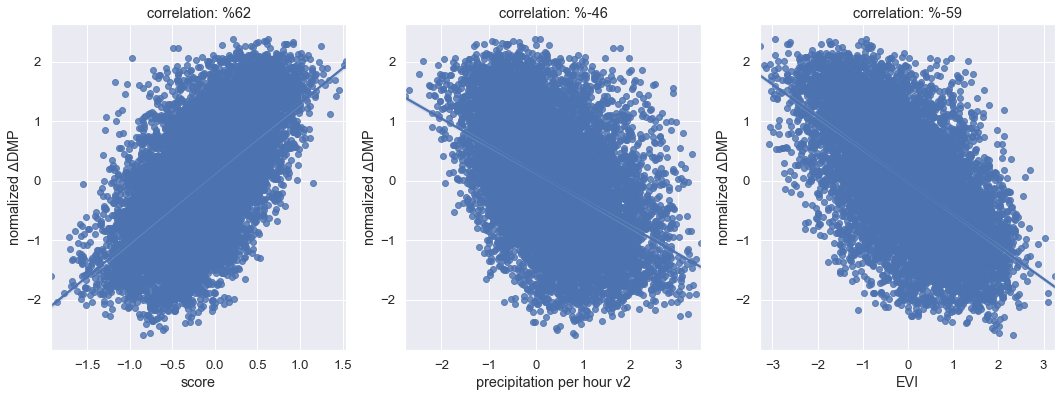

In [52]:
fig,axs = plt.subplots(1,3,figsize=(18, 6))

sns.regplot(data=monitor_data[['score','delta DMP']].dropna(),x='score',y='delta DMP',ax=axs[0])
cor = monitor_data[['score','delta DMP']].corr().values[1,0]
axs[0].set_ylabel(r'normalized $\Delta$DMP');
axs[0].title.set_text('correlation: %'+str(int(round(cor,2)*100)))

sns.regplot(data=monitor_data[['precipitation per hour v2','delta DMP']].dropna(),x='precipitation per hour v2',y='delta DMP',ax=axs[1])
cor = monitor_data[['precipitation per hour v2','delta DMP']].corr().values[1,0]
axs[1].set_ylabel(r'normalized $\Delta$DMP');
axs[1].title.set_text('correlation: %'+str(int(round(cor,2)*100)))

sns.regplot(data=monitor_data[['EVI','delta DMP']].dropna(),x='EVI',y='delta DMP', ax = axs[2])
cor = monitor_data[['EVI','delta DMP']].corr().values[1,0]
axs[2].set_ylabel(r'normalized $\Delta$DMP');
axs[2].title.set_text('correlation: %'+str(int(round(cor,2)*100)))

We expect $\Delta$DMP to positively correlate with our drought score. To confirm this, we applied the same preprocessing steps as outlined in Section \ref{generalizing-the-model-towards-a-drought-monitoring-tool} to $\Delta$DMP. That is, we averaged the data using a three-month temporal window and then standardized the data per month and district. We found a correlation of about %60 between this “normalized $\Delta$DMP” and our drought score (Figure \ref{fig_dmp_corr} left). Both components of the sore, namely precipitation (Figure \ref{fig_dmp_corr} middle) and EVI (Figure \ref{fig_dmp_corr} right) contribute to the correlation. As an example, Figure \ref{fig_dmp_2017} compares the drought score and normalized $\Delta$DMP across all Uganda districts in January 2017, and Figure \ref{fig_dmp_abim} shows the temporal variations of the two for the district of Abim. A good correlation is evident in both Figures. In this [Jupyter notebook](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/Uganda_logit_model.ipynb), it is possible to interactively change these two visualizations to explore different dates/districts.

We also found that the degree of correlation between the drought score and the normalized $\Delta$DMP depends on location: Figure \ref{fig_dmp_corr_districts} shows the correlation coefficient separately for each district, and the distribution of all the coefficients is displayed in Figure \ref{fig_dmp_corr_distribution}. While for 65% of the districts the correlation coefficient is higher than 60%, there are areas of adjacent districts with low correlation coefficient. Interestingly, some of the districts with the lowest correlation happen to be islands in Lake Victoria (compare Figure \ref{fig_dmp_corr_districts} with Figure \ref{fig_ugandamap}). Therefore, it is perhaps not surprising that the correlation breaks down in those districts. 

We hope that further investigation of the link between the drought score and DMP would lead to an improvement of the predictive power of our model.

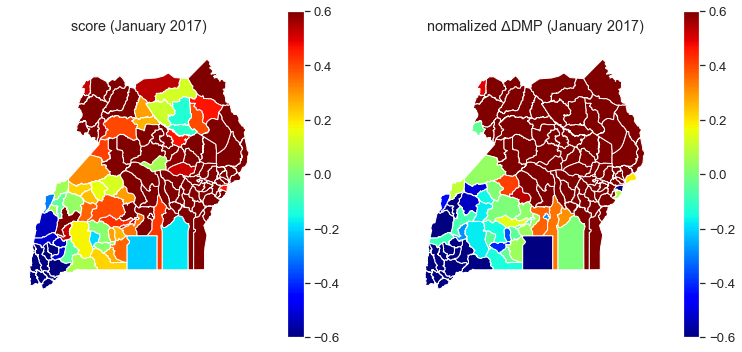

In [53]:
ibf.monitor_plot_dmp(monitor_data, date(2017,1,1))

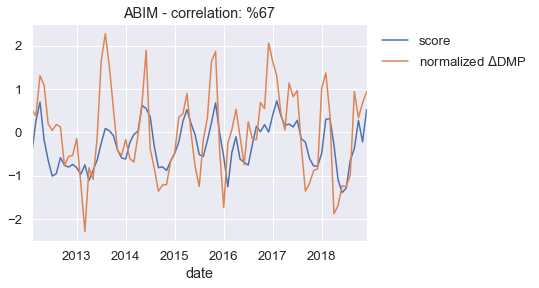

In [54]:
ibf.plot_timeseries(monitor_data, 'ABIM')

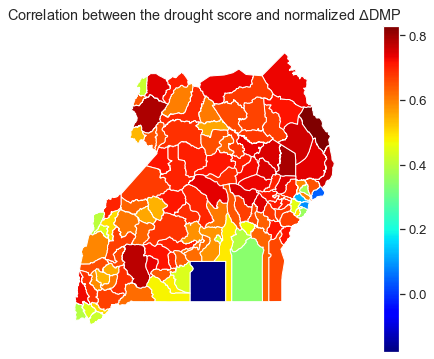

In [55]:
corr_data = ibf.plot_score_DMP_correlation(monitor_data, cmap='jet')

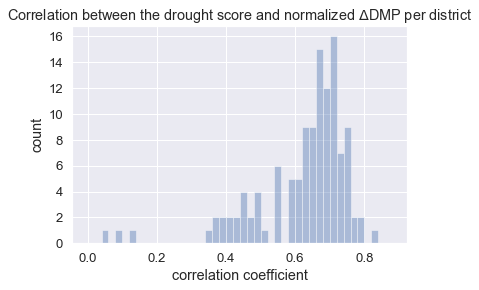

In [56]:
sns.distplot(corr_data['Correlation'],bins=np.arange(0,0.9,0.02),kde=False)
plt.yticks(range(0,18,2));
plt.xlabel('correlation coefficient')
plt.ylabel('count')
plt.title(r'Correlation between the drought score and normalized $\Delta$DMP per district');

![Map of Uganda (related to Figure \ref{fig_dmp_corr_districts}).](./pictures/Ugandamap.png){#fig_ugandamap placement='H' width=45%}

In [57]:
# Drought Monitor with DMP

slider2 = widgets.IntSlider(
        value=59,
        min=0,
        max=81,
        step=1,
        description='# Months:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
)

def monitor3(months):
    init_date = date(2012,2,1)
    monitor_date = init_date + relativedelta(months=months)
    ibf.monitor_plot_dmp(monitor_data, monitor_date, date_col='date', cmap='jet')

interact(monitor3,months=slider2);

interactive(children=(IntSlider(value=59, continuous_update=False, description='# Months:', max=81), Output())…

In [58]:
# Timeseries plots per district

districts = list(corr_data.sort_values('Correlation',ascending=False)['District'])

dropdown = widgets.Dropdown(
    options=list(districts),
    value='ABIM',
    description='district:',
    disabled=False,
)

def monitor4(district):
    ibf.plot_timeseries(monitor_data, district)

interact(monitor4,district=dropdown);

interactive(children=(Dropdown(description='district:', index=57, options=('MOROTO', 'KATAKWI', 'ARUA', 'KIRUH…

# Resources

This report has been generated from a [Jupyter notebook](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/Uganda_logit_model.ipynb). All the associated [datasets](https://github.com/rodekruis/IBF-system/tree/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/datasets), [python scrips](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/drought_ibf_utility.py) and the [\LaTeX source file](https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data/converted/Uganda_logit_model.tex) of this report can be accessed via the [Rodekruis GitHub](https://github.com/rodekruis/IBF-system/tree/master/trigger-model-development/drought/skill-assessment/Model%20Event%20Data). 
